## Health Data Reusability Project

This notebook is an informal investigation into the technologies needed to take the data contained in "open data" publications from the UK Department of Health. This will allow researchers to automate computations and respond more speedily to changes.

Some of this is ugly, some of it will doubtless be unnecessary, but it shows at least some of the preliminary work that goes into getting one's thinking straightened out about a particular program or set of programs.

In [2]:
import openpyxl as xl

Note that this softare cannot read ".xls" files. `wb = xl.load_workbook("data/gpearnextime.xls")` raises an exception, so I toook the quick route and converted it to a ".xlsx" file with Word before further processing.

It might be worth investigating the older `xlrd` module, which can reals ".xls" files (though sadly there appears
to be no easy way to write them out as ".xslx" files which I had hopes `xlwt` might have provided. I suspect that there will be an easy fix for this, but I'll need to speak to Chris Withers.

In [3]:
wb = xl.load_workbook("data/gpearnextime.xlsx")

/Users/sholden/Projects/HealthData/hd.env/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


In [4]:
wb.sheetnames

['Contents',
 'Definitions and Changes',
 '1a. GPMS Cash Terms ',
 '1b. GPMS Real Terms',
 'Real terms working - HIDE',
 '1c. GMS',
 '1d. PMS',
 '2a. GPMS Expenses',
 '2b. GMS Expenses',
 '2c. PMS Expenses',
 '3a. GPMS by Age ',
 '3b. GPMS by Age ',
 '4a. GPMS by Rurality ',
 '4b. GPMS by Rurality ',
 '5a. GPMS by Practice Size',
 '5b. GPMS by Practice Size',
 '6a. GPMS by SHA_GOR',
 '6b. GPMS by SHA_GOR ',
 '7a. GPMS by NHS ER',
 '7b. GPMS by NHS ER',
 '8. GPMS Distribution',
 '9a. All Salaried',
 '9b. Salaried by Country ',
 '9c. Salaried by Age',
 '9d. Salaried by Rurality',
 '9e. Salaried by SHA_GOR',
 '9f. Salaried by NHS ER',
 '10. Salaried Distribution ',
 '11. Combined GPs']

In [5]:
ws = wb.get_sheet_by_name('1a. GPMS Cash Terms ')

In [6]:
ws["B7"].value

'All Practice Types'

Many of the spreadsheets express an extra dimensionality in the data using a merged cell intended to apply to all rows next to it. Since the cell value is only given once (it can be extracted from the first cell in the merged range, the rest having no value) we need some way to replicate the values as we progress down the sheet.

Maybe a generator function taking the worksheet and the start position as an argument?

In [7]:
for i in range(1, 200):
    print(ws["B{}".format(i)].value, ws["C{}".format(i)].value)

Return to contents None
None None
GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS 
UK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND None
None None
GPMS UK None
Practice Type Year
All Practice Types 2002/031
None 2003/041
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Dispensing 2002/031
None 2003/041
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Non-Dispensing 2002/031,2
None 2003/041,2
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
None None
None None
GPMS ENGLAND None
Practice Type Year
All Practice Types 2002/03
None 2003/04
None 2004/05
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/11
None 2011/12
None 2012/13
All Dispensing 2002/03
None 2003/04
None 2004/053
None 2005/06
None 2006/07
None 2007/08
None 2008/09
None 2009/10
None 2010/

Note that the date values and the footnote numbers run together to give a single string value.
That means some parsing has to be applied to separate it into a `(date, footnote)` pair, whose
second member will be `None` if no notes apply.
From an openness point of view it wold be much better to have a separate column for the footnotes that should be applied to the row.

In [8]:
def repeat_merge(ws, row, col):
    last_value =  ws.cell(row=row, column=col).value
    if last_value is None:
        raise ValueError("Cell sequence must start with a non-empty cell")
    while not last_value.startswith("Copyright ©"):
        this_cell = ws.cell(row=row, column=col)
        if this_cell.value is not None:
            last_value = this_cell.value
        yield last_value
        row += 1

titles = repeat_merge(ws, 1, 2)

for i, t in enumerate(titles):
    print(i, t)

0 Return to contents
1 Return to contents
2 GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS 
UK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND
3 GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS 
UK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND
4 GPMS UK
5 Practice Type
6 All Practice Types
7 All Practice Types
8 All Practice Types
9 All Practice Types
10 All Practice Types
11 All Practice Types
12 All Practice Types
13 All Practice Types
14 All Practice Types
15 All Practice Types
16 All Practice Types
17 All Dispensing
18 All Dispensing
19 All Dispensing
20 All Dispensing
21 All Dispensing
22 All Dispensing
23 All Dispensing
24 All Dispensing
25 All Dispensing
26 All Dispensing
27 All Dispensing
28 All Non-Dispensing
29 All Non-Dispensing
30 All Non-Dispensing
31 All Non-Dispensing
32 All Non-Dispensing
33 All Non-Dispensing
34 All Non-Dispensing
35 All Non-Dispensing
36 All Non-Dispensing
37 All Non-Dispensing
38 All Non-Dispensing
39 All Non-Dispensing
40 All Non-Dispensing


Turns out that may not be as useful as I thought. It would probably be eaiser to maintain the column values as part ofthe processing logic.

(This was borne out when I wrote a non-terminting loop when experimenting with the code below)

In [9]:
ws["B3"].value

'GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS \nUK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND'

In [10]:
def year_refs(s):
    """Separate the year string into the year plus the list of references"""
    return s[:7], s[7:].split(",")

In [11]:
years = repeat_merge(ws, 6, 3)
for i in range(100):
    print(year_refs(next(years)))

('Year', [''])
('2002/03', ['1'])
('2003/04', ['1'])
('2004/05', [''])
('2005/06', [''])
('2006/07', [''])
('2007/08', [''])
('2008/09', [''])
('2009/10', [''])
('2010/11', [''])
('2011/12', [''])
('2012/13', [''])
('2002/03', ['1'])
('2003/04', ['1'])
('2004/05', [''])
('2005/06', [''])
('2006/07', [''])
('2007/08', [''])
('2008/09', [''])
('2009/10', [''])
('2010/11', [''])
('2011/12', [''])
('2012/13', [''])
('2002/03', ['1', '2'])
('2003/04', ['1', '2'])
('2004/05', [''])
('2005/06', [''])
('2006/07', [''])
('2007/08', [''])
('2008/09', [''])
('2009/10', [''])
('2010/11', [''])
('2011/12', [''])
('2012/13', [''])
('2012/13', [''])
('2012/13', [''])
('2012/13', [''])
('Year', [''])
('2002/03', [''])
('2003/04', [''])
('2004/05', [''])
('2005/06', [''])
('2006/07', [''])
('2007/08', [''])
('2008/09', [''])
('2009/10', [''])
('2010/11', [''])
('2011/12', [''])
('2012/13', [''])
('2002/03', [''])
('2003/04', [''])
('2004/05', ['3'])
('2005/06', [''])
('2006/07', [''])
('2007/08', [''])

In [12]:
ws["d81"].value

'-'

In [13]:
def num_val(val):
    return 0 if val == "-" else val

In [14]:
num_val(32.456)

32.456

In [15]:
num_val("-")

0

In [16]:
3 == "banana"

False

In [17]:
cell = ws["B3"]

Probably a good idea to look at how we can find the relevant areas in a worksheet, then analyze the content of those areas (which will vary in size, increasing as the years go by.

In [18]:
ws["B3"].value # Sheet heading

'GP EARNINGS AND EXPENSES 2002/03 TO 2012/13 CASH TERMS \nUK, ENGLAND, SCOTLAND, WALES, NORTHERN IRELAND'

In [19]:
ws["B5"].value # Table heading

'GPMS UK'

In [20]:
cells = ws.get_cell_collection()

In [21]:
from collections import defaultdict

cols_in_row = defaultdict(list)

for cell in cells:
    if cell.value is not None:
        cols_in_row[cell.row].append(cell.column)

In [22]:
max_row = max(c for c in sorted(cols_in_row.keys()))
max_row

198

Note that cell J43 has a spurious value that should really be ignored. Wonder how long that's been there and who knows it is ...

In [23]:
cols_in_row[43].remove('J')
cols_in_row[43]

['D', 'E', 'F', 'G', 'B', 'C']

In [177]:
pixels = [] # straight list of pixel values for graphic
matrix = []
#print("  ".join(list("ABCDEFG"))) # Column headings
for row_num in range(max_row):
    cols = cols_in_row[row_num]
    row_string = []
    row_matrix = []
    for col_name in "ABCDEFG":
        row_string.append("*" if col_name in cols else " ")
        row_matrix.append(col_name in cols)
    #print("  ".join(row_string))
    matrix.append(row_matrix)
    pixels += [1-p for p in row_matrix]

A  B  C  D  E  F  G


In [181]:
str_sizes = "".join(str(sum(x for x in row)) for row in matrix)

In [196]:
import re
for m in re.finditer("(?P<m>1665)", str_sizes):
    print(m.span()[0])

5
42
79
116
153


In [186]:
im = Image.new("1", (7, 198))

In [175]:
im.putdata(pixels)

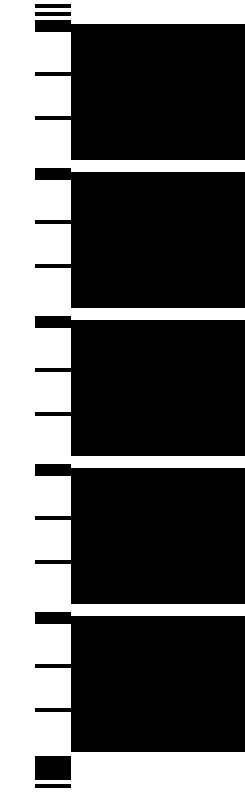

In [176]:
im.resize((245, 198*4))

In [ ]:
im = ImageColour

In [ ]:
im = ImageColour

In [ ]:
im = Image.Image

In [92]:
help(Image)

Help on module PIL.Image in PIL:

NAME
    PIL.Image

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # the Image class wrapper
    #
    # partial release history:
    # 1995-09-09 fl   Created
    # 1996-03-11 fl   PIL release 0.0 (proof of concept)
    # 1996-04-30 fl   PIL release 0.1b1
    # 1999-07-28 fl   PIL release 1.0 final
    # 2000-06-07 fl   PIL release 1.1
    # 2000-10-20 fl   PIL release 1.1.1
    # 2001-05-07 fl   PIL release 1.1.2
    # 2002-03-15 fl   PIL release 1.1.3
    # 2003-05-10 fl   PIL release 1.1.4
    # 2005-03-28 fl   PIL release 1.1.5
    # 2006-12-02 fl   PIL release 1.1.6
    # 2009-11-15 fl   PIL release 1.1.7
    #
    # Copyright (c) 1997-2009 by Secret Labs AB.  All rights reserved.
    # Copyright (c) 1995-2009 by Fredrik Lundh.
    #
    # See the README file for information on usage and redistribution.
    #

CLASSES
    builtins.RuntimeWarning(builtins.Warning)
        DecompressionBombWarning
    builtins.object
        Ima

In order to analyze the cell more fully the crummy visualization shows us we need to focus on Column B.

In [25]:
from itertools import count

def next_non_empty(r):
    for r in count(r):
        if ws["B{}".format(r)].value is not None:
            return r

In [27]:
r = 0
while r < max_row:
    r = next_non_empty(r+1)
    print(r)

1
3
5
6
7
18
29
42
43
44
55
66
79
80
81
92
103
116
117
118
129
140
153
154
155
166
177
189
190
191
192
193
194
196
198


In [28]:
2

2